# Balance Search
## Description
Traditionally cooling/heating degree variables are calculated using a static balance point. This fails to account for differences in specific building characteristics and HVAC systems.

## Imports

In [46]:
import calendar
import json

import numpy as np
import pandas as pd

from sqlalchemy import create_engine

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from joblib import Parallel, delayed, parallel_backend

## Helper functions

In [88]:
def degree_difference(reference_temp, temps, is_cooling=True):
    deltas = None
    
    if is_cooling:
        deltas = np.maximum(temps - reference_temp, 0)
    else:
        deltas = np.maximum(reference_temp - temps, 0)
        
    return deltas.sum(axis=1)


def score_balance(model_data, temps, balance, distance):
    temp_cooling = balance + distance/2.0
    temp_heating = balance - distance/2.0

    model_data['cdd'] = degree_difference(temp_cooling, temps, is_cooling=True)
    model_data['hdd'] = degree_difference(temp_heating, temps, is_cooling=False)
    
    lmod = smf.ols(
        formula = "usage ~ cdd + hdd + C(day_of_week)",
        data = model_data
    ).fit()
    
    fit = {
        'score': lmod.ssr,
        'balance': balance,
        'distance': distance,
    }
    
    return fit


def plotOptimizationSurface(results_df):
    z_data = results_df.pivot(index='balance', columns='distance', values='score')

    fig = go.Figure(data=[go.Surface(z=z_data.values)])

    fig.update_layout(
        title='Balance Search Scores', 
        autosize=False,     
        width=500, 
        height=500,        
        margin=dict(
            l=65, 
            r=50, 
            b=65, 
            t=90
        ),
        scene = dict(
            xaxis_title='Distance',
            yaxis_title='Balance Point - 40',
            zaxis_title='SSR'
        )
    )

    fig.show()
    
    
def plotDayOfWeekEffect(lmod):

    is_day_of_week_feature = ['C(day_of_week)' in feature or feature == 'Intercept' for feature in lmod.conf_int().index]
    conf_int_widths = lmod.conf_int()[is_day_of_week_feature].diff(axis=1)[1]
    conf_int_widths

    fig = go.Figure(data=go.Scatter(
            x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            y=[ lmod.params['C(day_of_week)[T.Monday]'],
                lmod.params['C(day_of_week)[T.Tuesday]'],
                lmod.params['C(day_of_week)[T.Wednesday]'],
                lmod.params['C(day_of_week)[T.Thursday]'],
                0, # Friday was the default treatment variable
                lmod.params['C(day_of_week)[T.Saturday]'],
                lmod.params['C(day_of_week)[T.Sunday]']
            ],
            error_y=dict(
                type='data', # value of error bar given in data coordinates
                array=[ conf_int_widths['C(day_of_week)[T.Monday]'],
                        conf_int_widths['C(day_of_week)[T.Tuesday]'],
                        conf_int_widths['C(day_of_week)[T.Wednesday]'],
                        conf_int_widths['C(day_of_week)[T.Thursday]'],
                        conf_int_widths['Intercept'],
                        conf_int_widths['C(day_of_week)[T.Saturday]'],
                        conf_int_widths['C(day_of_week)[T.Sunday]']
                ],
                visible=True)
        ))
    fig.show()


def plotModel(balance, distance, data_dataid, lmod):
    usage_pred = lmod.fittedvalues

    temp_cooling = balance + distance/2.0
    temp_heating = balance - distance/2.0

    # separate the heating and cooling plot lines if they are at the same value
    heat_cool_plot_offset = 0
    if temp_cooling == temp_heating:
        heat_cool_plot_offset = 0.33

    plt.scatter(
        data_dataid['avg_temp'], 
        data_dataid['usage'], 
        label='Observed'
    )

    plt.scatter(
        data_dataid['avg_temp'], 
        usage_pred, 
        label='Model'
    )

    plt.axvline(
        x=temp_cooling+heat_cool_plot_offset, 
        label='Cooling: %d F'%temp_cooling,
        c='blue',
        linestyle='dashed'
    )

    plt.axvline(
        x=temp_heating-heat_cool_plot_offset, 
        label='Heating: %d F'%temp_heating, 
        c='red',
        linestyle='dashed'
    )


    plt.title('dataid: ' + str(dataid))
    plt.xlabel('Temperature, F')
    plt.ylabel('Usage kWh')
    plt.legend()
    plt.show()

## Database connection

In [2]:
# load credentials
credentials_file_path = '../credentials.json'
with open(credentials_file_path) as credentials_file:
    credentials = json.load(credentials_file)
    
# connect to database
engine = create_engine('mysql+mysqldb://{user}@{host}/{db}'.format(
    user = credentials['user'],
    host = credentials['host'],
    db = credentials['db']
))

conn = engine.connect()

## Load the data

In [3]:
data = pd.read_sql('SELECT * FROM model_data', conn)

# filter out suspect temperature values
data = data[data['avg_temp'] > -100].copy()

data['usage'] = data['usage'] + data['solar']

# convert temperature from C to F
data['avg_temp'] = (data['avg_temp']*(9.0/5.0))+32

# convert usage from Wh to kWh
data['usage'] = data['usage']/1000.0

# use the actual datetime class
data['dt'] = pd.to_datetime(data['dt'])

# make a day of the week category
data['day_of_week'] = data['dt'].apply(lambda dt: calendar.day_name[dt.weekday()])

# convert array column back into an actual array, it's currently a string
# Note: we also convert from Celcius to Farenheit while we're in the array
data['hourly_temps'] = data['hourly_temps'].apply(lambda hourly_temps: [(float(hourly_temp)*(9.0/5.0))+32 for hourly_temp in hourly_temps.replace('[', '').replace(']', '').split(',')])

# output
data

,city_state,year,month,day,dataid,dt,cooling,furnace,heaters,heating,solar,usage,avg_temp,hourly_temps,day_of_week
0,"Austin, Texas",2018,1,2,661,2018-01-02 00:00:00-06:00,0.000,337.424,0.0,337.424,275.095,1.281377,24.650,"[25.16, 24.8, 25.16, 24.98, 24.8, 24.8, 24.62,...",Tuesday
1,"Austin, Texas",2018,1,2,1642,2018-01-02 00:00:00-06:00,2.474,0.000,0.0,0.000,261.061,1.198648,24.650,"[25.16, 24.8, 25.16, 24.98, 24.8, 24.8, 24.62,...",Tuesday
2,"Austin, Texas",2018,1,2,2335,2018-01-02 00:00:00-06:00,2.275,475.461,0.0,475.461,236.227,1.428540,24.650,"[25.16, 24.8, 25.16, 24.98, 24.8, 24.8, 24.62,...",Tuesday
3,"Austin, Texas",2018,1,2,2361,2018-01-02 00:00:00-06:00,47.886,419.124,0.0,419.124,254.814,-0.677539,24.650,"[25.16, 24.8, 25.16, 24.98, 24.8, 24.8, 24.62,...",Tuesday
4,"Austin, Texas",2018,1,2,2818,2018-01-02 00:00:00-06:00,0.242,399.285,0.0,399.285,243.497,0.985386,24.650,"[25.16, 24.8, 25.16, 24.98, 24.8, 24.8, 24.62,...",Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,"Austin, Texas",2018,12,31,8565,2018-12-31 00:00:00-06:00,38.654,439.949,0.0,439.949,0.000,1.551472,44.675,"[38.480000000000004, 38.3, 37.94, 38.12, 37.94...",Monday
8641,"Austin, Texas",2018,12,31,9019,2018-12-31 00:00:00-06:00,1.424,49.241,0.0,49.241,264.470,1.085366,44.675,"[38.480000000000004, 38.3, 37.94, 38.12, 37.94...",Monday
8642,"Austin, Texas",2018,12,31,9160,2018-12-31 00:00:00-06:00,0.408,137.032,0.0,137.032,631.769,0.718530,44.675,"[38.480000000000004, 38.3, 37.94, 38.12, 37.94...",Monday
8643,"Austin, Texas",2018,12,31,9278,2018-12-31 00:00:00-06:00,1205.246,208.127,0.0,208.127,793.183,2.976680,44.675,"[38.480000000000004, 38.3, 37.94, 38.12, 37.94...",Monday


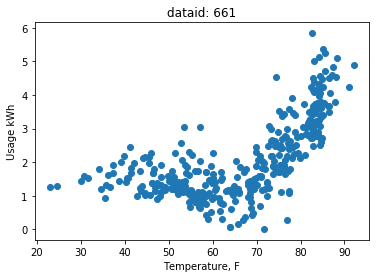

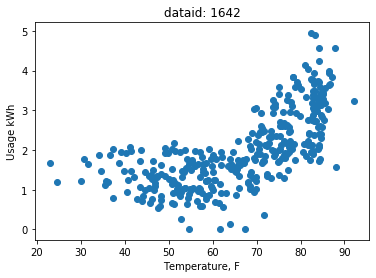

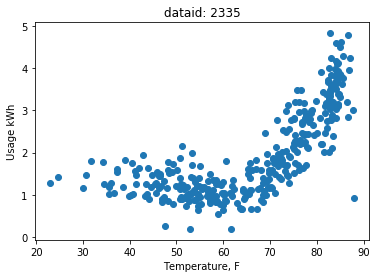

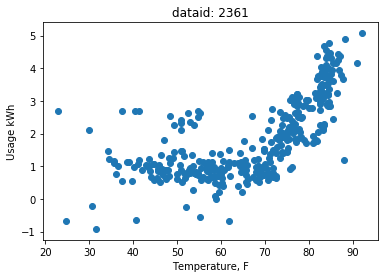

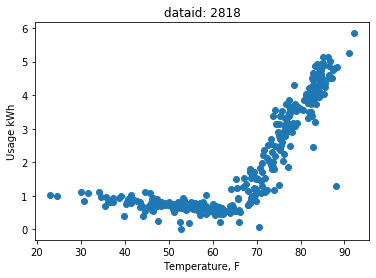

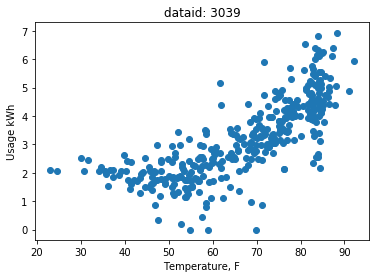

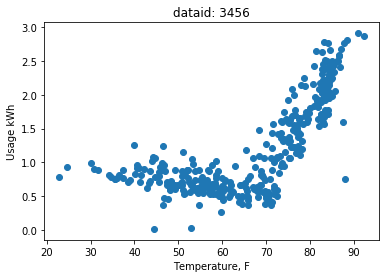

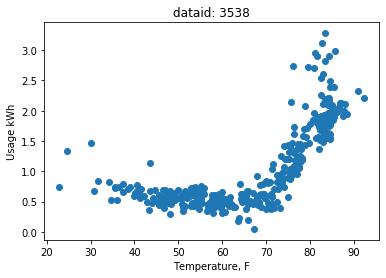

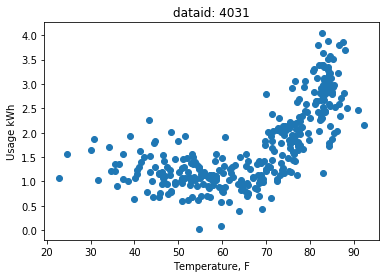

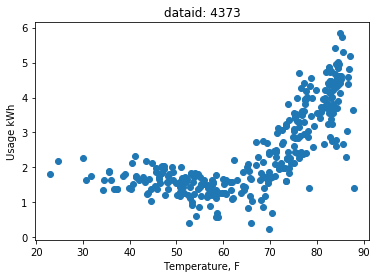

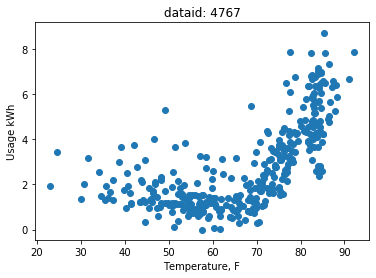

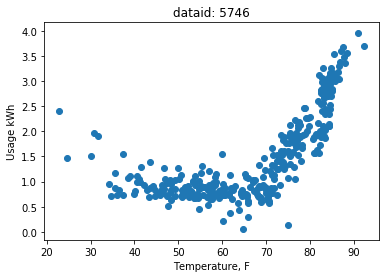

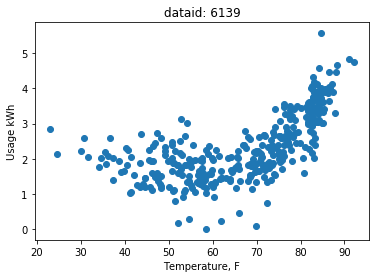

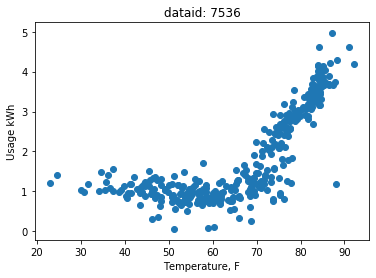

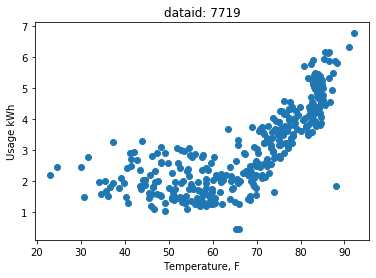

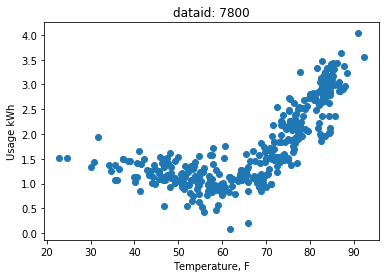

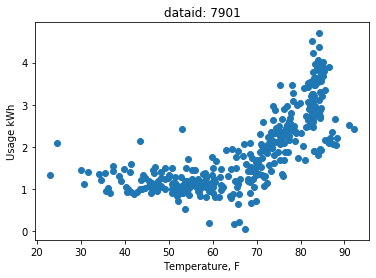

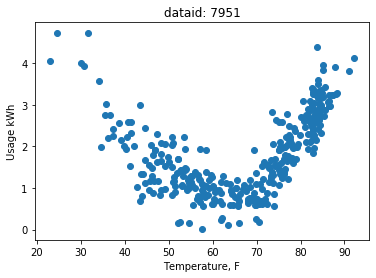

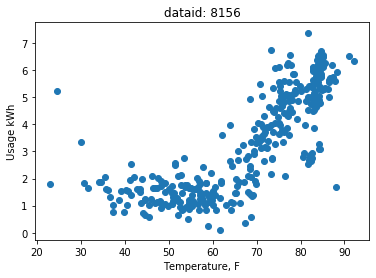

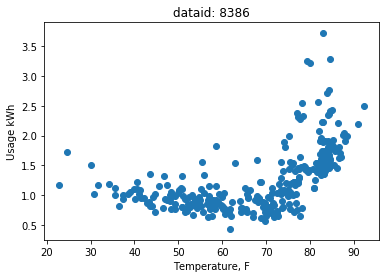

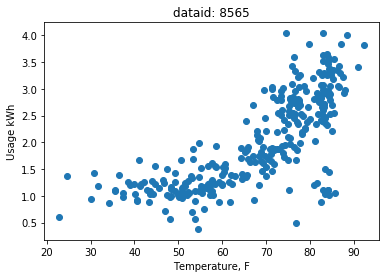

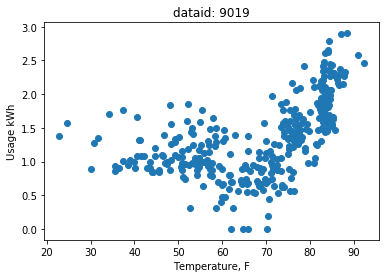

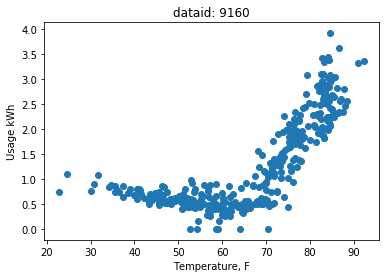

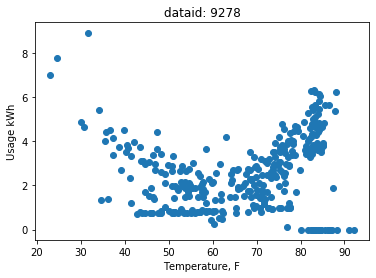

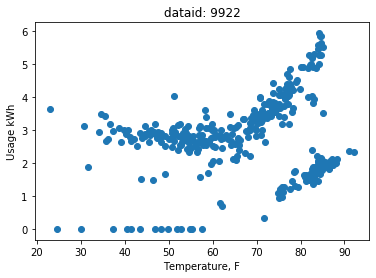

In [6]:
dataids = data['dataid'].unique()
for dataid in dataids:
    data_dataid = data[data['dataid'] == dataid]

    plt.title('dataid: ' + str(dataid))
    plt.scatter(data_dataid['avg_temp'], data_dataid['usage'])
    plt.xlabel('Temperature, F')
    plt.ylabel('Usage kWh')
    plt.show()

## Run the balance search

In [266]:
balances = np.arange(40,81)
distances = np.arange(0,21)

results_dataids = []

for dataid in dataids:
    data_dataid = data[data['dataid'] == dataid].copy()

    temps = np.array(data_dataid['hourly_temps'].tolist())

    with parallel_backend('loky', n_jobs=-1):
        results = Parallel()(delayed(score_balance)(data_dataid, temps, balance, distance) for balance in balances for distance in distances)

    results_dataids.append({
        'dataid': dataid,
        'results': results
    })


## Look at the optimization surface

In [100]:
results_dataid = results_dataids[0]
df = pd.DataFrame(results_dataid['results'])
best_fit = df.iloc[df['score'].idxmin()]

results_dataid['best_score'] = best_fit['score']
results_dataid['best_balance'] = best_fit['balance']
results_dataid['best_distance'] = best_fit['distance']

results_df = pd.DataFrame(results_dataid['results'])
plotOptimizationSurface(results_df)

## Examine the best models

   df_resid         ssr  df_diff    ss_diff          F        Pr(>F)
0     353.0  129.892470      0.0        NaN        NaN           NaN
1     347.0  109.190244      6.0  20.702227  10.965071  3.421512e-11


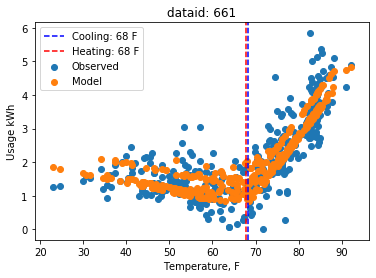

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  usage   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     140.8
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          4.52e-104
Time:                        09:02:33   Log-Likelihood:                -294.77
No. Observations:                 356   AIC:                             607.5
Df Residuals:                     347   BIC:                             642.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.8000      0.099      8.112      0.000       0.606       0.994
C(day_of_week)[T.Monday]       -0.0094      0.111     -0.085      0.932      -0.227       0.208
C(day_of_week)[T.Saturday]      0.4751      0.111      4.275      0.000       0.257       0.694
C(day_of_week)[T.Sunday]        0.4279      0.111      3.869      0.000       0.210       0.645
C(day_of_week)[T.Thursday]     -0.1382      0.111     -1.250      0.212      -0.356       0.079
C(day_of_week)[T.Tuesday]      -0.1286      0.111     -1.157      0.248      -0.347       0.090
C(day_of_week)[T.Wednesday]    -0.0915      0.111     -0.827      0.409      -0.309       0.126
cdd                             0.0072      0.000     28.002      0.000       0.007       0.008
hdd                             0.0011      0.000      6.267      0.000       0.001       0.001
==============================================================================
Omnibus:                       30.893   Durbin-Watson:                   1.367
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.722
Skew:                           0.239   Prob(JB):                     3.33e-25
Kurtosis:                       5.715   Cond. No.                     2.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [267]:
# which dataid to look at
i = 0

# grab the results for the current datatid
results_dataid = results_dataids[i]

# pull out the results as a pandas dataframe
df = pd.DataFrame(results_dataid['results'])

# grab the best scoring balance parameters
best_fit = df.iloc[df['score'].idxmin()]

# get the dataid from the results dict
dataid = results_dataid['dataid']

# fetch the data for the current dataid
data_dataid = data[data['dataid'] == dataid].copy()

# extract hourly temperatures as a numpy array
temps = np.array(data_dataid['hourly_temps'].tolist())

# recalculate the degree difference from the best model
temp_cooling = best_fit['balance'] + best_fit['distance']/2.0
data_dataid['cdd'] = degree_difference(temp_cooling, temps, is_cooling=True)
temp_heating = best_fit['balance'] - best_fit['distance']/2.0
data_dataid['hdd'] = degree_difference(temp_heating, temps, is_cooling=False)

# rebuild the best model
lmod = smf.ols(
    formula = "usage ~ cdd + hdd + C(day_of_week)",
    data = data_dataid
).fit()

# fit a model without the day of the week to compare if it was useful
lmod_no_dow = smf.ols(
    formula = "usage ~ cdd + hdd",
    data = data_dataid
).fit()

# use ANOVA to determine if we should keep the day of the week feature
anova_results = anova_lm(lmod_no_dow, lmod)
print(anova_results)
has_day_of_week = anova_results['Pr(>F)'][1] < 0.05
if not has_day_of_week:
    lmod = lmod_no_dow
else:
    plotDayOfWeekEffect(lmod)
    
# plot the model vs the observed
plotModel(best_fit['balance'], best_fit['distance'], data_dataid, lmod)

# output the model summary table
lmod.summary()

## Look at our predicted heating/cooling vs actual

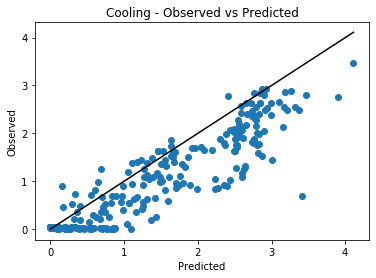

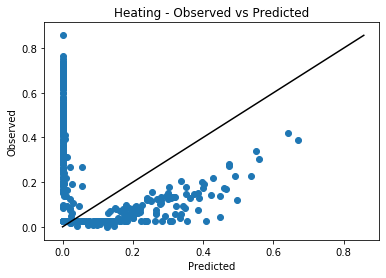

In [253]:
pred_cooling = (lmod.model.exog[:, lmod.params.index == 'cdd'] * lmod.params['cdd']).flatten()
pred_heating = (lmod.model.exog[:, lmod.params.index == 'hdd'] * lmod.params['hdd']).flatten()

actual_cooling = data_dataid['cooling']/1000
actual_heating = data_dataid['heating']/1000

total_cooling_actual = sum(actual_cooling)
total_cooling_pred = sum(pred_cooling)

total_heating_actual = sum(actual_heating)
total_heating_pred = sum(pred_heating)

plt.title('Cooling - Observed vs Predicted')
plt.scatter(pred_cooling, actual_cooling)
max_cooling = max(pred_cooling.max(), actual_cooling.max())
plt.plot([0,max_cooling],[0,max_cooling],c='black')
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.show()

plt.title('Heating - Observed vs Predicted')
plt.scatter(pred_heating, actual_heating)
max_heating = max(pred_heating.max(), actual_heating.max())
plt.plot([0,max_heating],[0,max_heating],c='black')
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.show()

## Extract some values from the best fit models for later analysis

In [284]:
cleaned_results = []

for cur_results_dataid in results_dataids:
    results_dataid = cur_results_dataid.copy()

    df = pd.DataFrame(results_dataid['results'])
    best_fit = df.iloc[df['score'].idxmin()]

    dataid = results_dataid['dataid']
    data_dataid = data[data['dataid'] == dataid].copy()

    temps = np.array(data_dataid['hourly_temps'].tolist())

    temp_cooling = best_fit['balance'] + best_fit['distance']/2.0
    temp_heating = best_fit['balance'] - best_fit['distance']/2.0

    results_dataid['temp_cooling'] = temp_cooling
    results_dataid['temp_heating'] = temp_heating

    data_dataid['cdd'] = degree_difference(temp_cooling, temps, is_cooling=True)
    data_dataid['hdd'] = degree_difference(temp_heating, temps, is_cooling=False)

    lmod = smf.ols(
        formula = "usage ~ cdd + hdd + C(day_of_week)",
        data = data_dataid
    ).fit()

    lmod_no_dow = smf.ols(
        formula = "usage ~ cdd + hdd",
        data = data_dataid
    ).fit()

    anova_results = anova_lm(lmod_no_dow, lmod)

    has_day_of_week = anova_results['Pr(>F)'][1] < 0.05
    if not has_day_of_week:
        lmod = lmod_no_dow

    results_dataid['r2'] = lmod.rsquared

    pred_cooling = (lmod.model.exog[:, lmod.params.index == 'cdd'] * lmod.params['cdd']).flatten()
    pred_heating = (lmod.model.exog[:, lmod.params.index == 'hdd'] * lmod.params['hdd']).flatten()

    actual_cooling = data_dataid['cooling']/1000
    actual_heating = data_dataid['heating']/1000

    total_cooling_actual = sum(actual_cooling)
    total_cooling_pred = sum(pred_cooling)

    total_heating_actual = sum(actual_heating)
    total_heating_pred = sum(pred_heating)

    results_dataid['cooling_pred'] = total_cooling_pred
    results_dataid['cooling_actual'] = total_cooling_actual
    results_dataid['heating_pred'] = total_heating_pred
    results_dataid['heating_actual'] = total_heating_actual

    del results_dataid['results']

    cleaned_results.append(results_dataid)
    
cleaned_results = pd.DataFrame(cleaned_results)
cleaned_results = cleaned_results.set_index('dataid')
cleaned_results

,dataid,temp_cooling,temp_heating,r2,cooling_pred,cooling_actual,heating_pred,heating_actual
0,661,68.0,68.0,0.764478,365.992010,227.336181,68.038496,82.170722
1,1642,61.0,59.0,0.601108,309.789162,194.134820,22.330486,122.835869
2,2335,65.0,65.0,0.809245,361.364843,260.837272,45.597750,109.247848
3,2361,67.5,66.5,0.712820,370.673348,267.919643,35.966669,85.048839
4,2818,64.0,64.0,0.923885,565.933720,372.947116,41.206601,127.055275
5,3039,56.0,46.0,0.697176,521.924565,427.233674,11.203256,0.000000
6,3456,67.0,67.0,0.831983,232.678299,171.082050,29.959641,65.121982
7,3538,66.0,66.0,0.810244,234.456659,135.308519,35.952499,50.952543
8,4031,65.0,65.0,0.734121,278.988785,0.000000,38.345054,58.222450
9,4373,63.5,62.5,0.771131,427.604609,287.415519,45.198985,115.551474


In [288]:
cleaned_results

,temp_cooling,temp_heating,r2,cooling_pred,cooling_actual,heating_pred,heating_actual
dataid,,,,,,,
661,68.0,68.0,0.764478,365.992010,227.336181,68.038496,82.170722
1642,61.0,59.0,0.601108,309.789162,194.134820,22.330486,122.835869
2335,65.0,65.0,0.809245,361.364843,260.837272,45.597750,109.247848
2361,67.5,66.5,0.712820,370.673348,267.919643,35.966669,85.048839
2818,64.0,64.0,0.923885,565.933720,372.947116,41.206601,127.055275
3039,56.0,46.0,0.697176,521.924565,427.233674,11.203256,0.000000
3456,67.0,67.0,0.831983,232.678299,171.082050,29.959641,65.121982
3538,66.0,66.0,0.810244,234.456659,135.308519,35.952499,50.952543
4031,65.0,65.0,0.734121,278.988785,0.000000,38.345054,58.222450


## Load the metadata

In [305]:
# load the raw metadata csv file
metadata = pd.read_csv('../data/metadata.csv')

# get rid of the first description row 
metadata = metadata[1:].copy()

metadata['dataid'] = metadata['dataid'].astype(int)

# combine city and state into a single column for joining
metadata['city_state'] = metadata['city'] + ', ' + metadata['state']

# prepare for join, we only want the join key (dataid) and a few features
metadata = metadata[[
    'dataid', 
    'city_state', 
    'house_construction_year', 
    'total_square_footage', 
    'building_type'
]].set_index('dataid')

# make sure these are floats and not strings
metadata['total_square_footage'] = metadata['total_square_footage'].astype(float)
metadata['house_construction_year'] = metadata['house_construction_year'].astype(float)

# output
metadata

,city_state,house_construction_year,total_square_footage,building_type
dataid,,,,
2836,"Austin, Texas",1994.0,2796.0,Single-Family Home 001 (Master)
2743,"Austin, Texas",1949.0,1590.0,Single-Family Home 001 (Master)
5323,"Austin, Texas",2008.0,1185.0,Single-Family Home 001 (Master)
8560,"Austin, Texas",2009.0,2001.0,Single-Family Home 001 (Master)
3313,"Austin, Texas",2007.0,2001.0,Single-Family Home 001 (Master)
...,...,...,...,...
891,"Austin, Texas",NaN,NaN,Single-Family Home 001 (Master)
6601,"Austin, Texas",NaN,NaN,Single-Family Home 001 (Master)
114,"Austin, Texas",2008.0,1842.0,Single-Family Home 001 (Master)


In [306]:
joined = cleaned_results.join(metadata)

joined['cooling_pred_sqft'] = joined['cooling_pred'] / joined['total_square_footage']
joined['cooling_actual_sqft'] = joined['cooling_actual'] / joined['total_square_footage']
joined['heating_pred_sqft'] = joined['heating_pred'] / joined['total_square_footage']
joined['heating_actual_sqft'] = joined['heating_actual'] / joined['total_square_footage']

In [307]:
joined

,temp_cooling,temp_heating,r2,cooling_pred,cooling_actual,heating_pred,heating_actual,city_state,house_construction_year,total_square_footage,building_type,cooling_pred_sqft,cooling_actual_sqft,heating_pred_sqft,heating_actual_sqft
dataid,,,,,,,,,,,,,,,
661,68.0,68.0,0.764478,365.992010,227.336181,68.038496,82.170722,"Austin, Texas",2007.0,1842.0,Single-Family Home 001 (Master),0.198693,0.123418,0.036937,0.044610
1642,61.0,59.0,0.601108,309.789162,194.134820,22.330486,122.835869,"Austin, Texas",2007.0,1720.0,Single-Family Home 001 (Master),0.180110,0.112869,0.012983,0.071416
2335,65.0,65.0,0.809245,361.364843,260.837272,45.597750,109.247848,"Austin, Texas",2008.0,2710.0,Single-Family Home 001 (Master),0.133345,0.096250,0.016826,0.040313
2361,67.5,66.5,0.712820,370.673348,267.919643,35.966669,85.048839,"Austin, Texas",2009.0,3245.0,Single-Family Home 001 (Master),0.114229,0.082564,0.011084,0.026209
2818,64.0,64.0,0.923885,565.933720,372.947116,41.206601,127.055275,"Austin, Texas",2007.0,2345.0,Single-Family Home 001 (Master),0.241336,0.159039,0.017572,0.054181
3039,56.0,46.0,0.697176,521.924565,427.233674,11.203256,0.000000,"Austin, Texas",2010.0,3246.0,Single-Family Home 001 (Master),0.160790,0.131619,0.003451,0.000000
3456,67.0,67.0,0.831983,232.678299,171.082050,29.959641,65.121982,"Austin, Texas",2008.0,1720.0,Single-Family Home 001 (Master),0.135278,0.099466,0.017418,0.037862
3538,66.0,66.0,0.810244,234.456659,135.308519,35.952499,50.952543,"Austin, Texas",2007.0,1720.0,Single-Family Home 001 (Master),0.136312,0.078668,0.020903,0.029624
4031,65.0,65.0,0.734121,278.988785,0.000000,38.345054,58.222450,"Austin, Texas",2007.0,1946.0,Single-Family Home 001 (Master),0.143365,0.000000,0.019705,0.029919


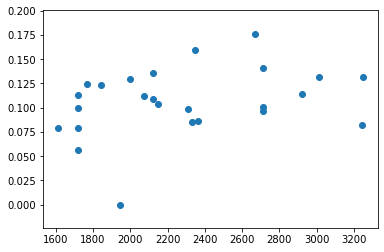

In [319]:
plt.scatter(joined['total_square_footage'], joined['cooling_actual_sqft'])

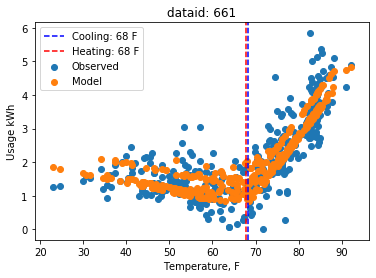

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  usage   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     140.8
Date:                Sun, 30 Aug 2020   Prob (F-statistic):          4.52e-104
Time:                        22:21:56   Log-Likelihood:                -294.77
No. Observations:                 356   AIC:                             607.5
Df Residuals:                     347   BIC:                             642.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.8000      0.099      8.112      0.000       0.606       0.994
C(day_of_week)[T.Monday]       -0.0094      0.111     -0.085      0.932      -0.227       0.208
C(day_of_week)[T.Saturday]      0.4751      0.111      4.275      0.000       0.257       0.694
C(day_of_week)[T.Sunday]        0.4279      0.111      3.869      0.000       0.210       0.645
C(day_of_week)[T.Thursday]     -0.1382      0.111     -1.250      0.212      -0.356       0.079
C(day_of_week)[T.Tuesday]      -0.1286      0.111     -1.157      0.248      -0.347       0.090
C(day_of_week)[T.Wednesday]    -0.0915      0.111     -0.827      0.409      -0.309       0.126
cdd                             0.0072      0.000     28.002      0.000       0.007       0.008
hdd                             0.0011      0.000      6.267      0.000       0.001       0.001
==============================================================================
Omnibus:                       30.893   Durbin-Watson:                   1.367
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.722
Skew:                           0.239   Prob(JB):                     3.33e-25
Kurtosis:                       5.715   Cond. No.                     2.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
balance = best_fit['balance']
distance = best_fit['distance']

temp_cooling = balance + distance/2.0
temp_heating = balance - distance/2.0

data_dataid['cdd'] = degree_difference(temp_cooling, temps, is_cooling=True)
data_dataid['hdd'] = degree_difference(temp_heating, temps, is_cooling=False)

lmod = smf.ols(
    formula = "usage ~ cdd + hdd + C(day_of_week)",
    data = data_dataid
).fit()




lmod.summary()

In [137]:
lmod.model.exdog[lmod.params.index == 'cdd']

IndexError: boolean index did not match indexed array along dimension 0; dimension is 356 but corresponding boolean dimension is 9

In [160]:
lmod.model.exog * lmod.params.values

array([[ 0.79996212, -0.        ,  0.        , ..., -0.        ,
         0.        ,  1.11773108],
       [ 0.79996212, -0.        ,  0.        , ..., -0.09148059,
         0.        ,  0.98004518],
       [ 0.79996212, -0.        ,  0.        , ..., -0.        ,
         0.        ,  0.63099594],
       ...,
       [ 0.79996212, -0.        ,  0.47511313, ..., -0.        ,
         0.        ,  0.72633183],
       [ 0.79996212, -0.        ,  0.        , ..., -0.        ,
         0.        ,  0.78937341],
       [ 0.79996212, -0.00938512,  0.        , ..., -0.        ,
         0.        ,  0.60140894]])

In [165]:
model = lmod.model
model.exog_names

['Intercept',
 'C(day_of_week)[T.Monday]',
 'C(day_of_week)[T.Saturday]',
 'C(day_of_week)[T.Sunday]',
 'C(day_of_week)[T.Thursday]',
 'C(day_of_week)[T.Tuesday]',
 'C(day_of_week)[T.Wednesday]',
 'cdd',
 'hdd']

In [153]:
pred_cooling = (lmod.model.exog[:, lmod.params.index == 'cdd'] * lmod.params['cdd']).flatten()
pred_heating = (lmod.model.exog[:, lmod.params.index == 'hdd'] * lmod.params['hdd']).flatten()

In [280]:
sum(np.maximum(data_dataid['cooling']/1000, 0))

194.13481999999993

In [278]:
sum(pred_cooling)

309.78916177240063

In [276]:
sum(np.maximum(data_dataid['heating']/1000, 0))

122.835869

In [277]:
sum(pred_heating)

22.33048640777332

In [48]:
# load the raw metadata csv file
metadata = pd.read_csv('../data/metadata.csv')

# get rid of the first description row 
metadata = metadata[1:].copy()

metadata['dataid'] = metadata['dataid'].astype(int)

# combine city and state into a single column for joining
metadata['city_state'] = metadata['city'] + ', ' + metadata['state']

# prepare for join, we only want the join key (dataid) and a few features
metadata = metadata[[
    'dataid', 
    'city_state', 
    'house_construction_year', 
    'total_square_footage', 
    'building_type'
]].set_index('dataid')

# output
metadata

,city_state
dataid,
2836,"Austin, Texas"
2743,"Austin, Texas"
5323,"Austin, Texas"
8560,"Austin, Texas"
3313,"Austin, Texas"
...,...
891,"Austin, Texas"
6601,"Austin, Texas"
114,"Austin, Texas"
